In [1]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from keras.models import save_model
import keras
from keras.datasets import cifar10, fashion_mnist
from keras.models import load_model
from keras.callbacks import TensorBoard
from annoy import AnnoyIndex

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import UpSampling2D, Reshape, Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, InputLayer
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import yagmail
import os

%matplotlib inline

/home/nicoroble/anaconda3/envs/tensorflow-gpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
email = os.environ.get('GMAIL')
pswd = os.environ.get('GMAILPASS')
yag = yagmail.SMTP(email, pswd)

In [3]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)

In [41]:
reset_tf_session()

In [48]:
bit_size = 32
autoencoder_id='final01'
model_path = 'fashion-models/'

In [49]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [50]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (60000, 28, 28) (60000,)
Test samples: (10000, 28, 28) (10000,)


In [51]:
x_train = x_train.reshape([-1, 28, 28, 1])
x_test = x_test.reshape([-1, 28, 28, 1])

IMG_SHAPE = x_train.shape[1:]

# center images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [52]:
model_path

'fashion-models/bitsize32/1024architecture/'

In [53]:
autoencoder = load_model(F'{model_path}autoencoder{autoencoder_id}.h5')
encoder = load_model(F'{model_path}encoder{autoencoder_id}.h5')
decoder = load_model(F'{model_path}decoder{autoencoder_id}.h5')

TypeError: ('Keyword argument not understood:', 'data_format')

In [54]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code)[0].reshape(28,28)

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

In [12]:
def show_image(x):
    plt.imshow(x.reshape(28,28), cmap='gray')

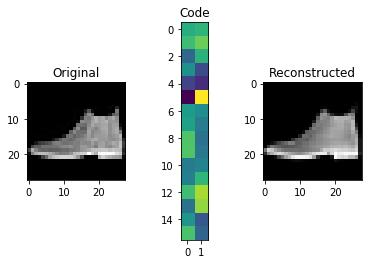

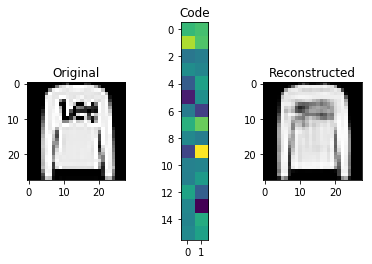

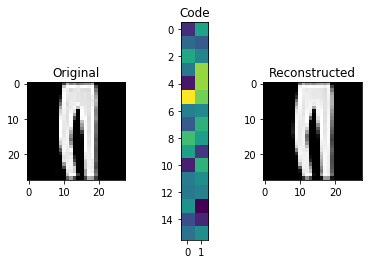

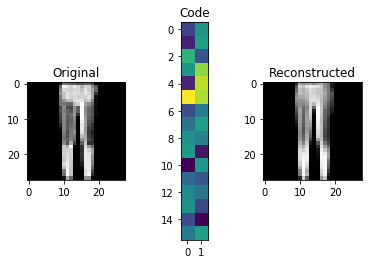

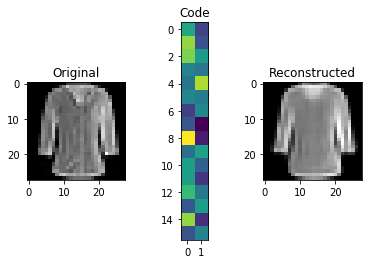

In [13]:
for i in range(5):
    img = x_test[i]
    visualize(img,encoder,decoder)

In [14]:
images = x_test
codes = encoder.predict(images)

In [15]:
annoy_index = AnnoyIndex(bit_size, metric='angular')
for i in range(len(codes)):
    annoy_index.add_item(i, codes[i])

In [16]:
annoy_index.build(1000)

True

In [17]:
yag.send('mizutaninikkou@gmail.com', subject = "Training Done", contents='Training Done')

{}

In [18]:
def get_similar_annoy(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    (images, distances) = annoy_index.get_nns_by_vector(vector=code[0], n=n_neighbors, include_distances=True, search_k=200000)
    
    return images, distances

In [19]:
def show_similar_annoy(image):
    neighbors, distances = get_similar_annoy(image,n_neighbors=5)
    
    plt.figure(figsize=[10,10])
    plt.subplot(1,6,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(5):
        plt.subplot(1,6,i+2)
        show_image(x_test[neighbors[i]])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [20]:
def get_accuracy(image_index, top_n=1):
    true_class = y_test[image_index]
    image = x_test[image_index]
    
    neighbors, distances = get_similar_annoy(image,n_neighbors=top_n)
    
    predict = []
    
    for neighbor in neighbors:
        predict.append(x_test[neighbor])
    
    scores = []
    
    for i in range(len(predict)):
        if i == 0:
            continue
        if y_test[neighbors[i]] == true_class:
            scores.append(1)
        else:
            scores.append(0)
    
    return np.mean(scores)

In [21]:
accuracies = []
for i in range(len(x_test)):
    accuracies.append(get_accuracy(i, top_n=2))

accuracy = np.mean(accuracies)
print(accuracy)

0.9152


In [22]:
contents = F'Calculation for accuracy has finished. Accuracy for {autoencoder_id} is {accuracy}'
yag.send('mizutaninikkou@gmail.com', subject = "Accuracy Prediction", contents=contents)

{}

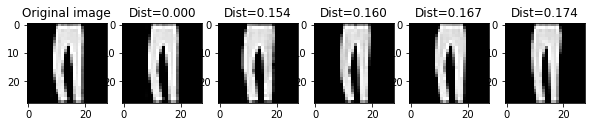

In [23]:
show_similar_annoy(x_test[2])

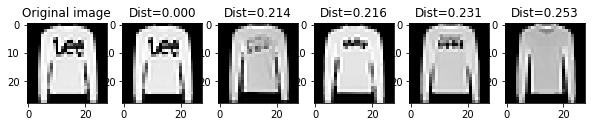

In [24]:
show_similar_annoy(x_test[1])

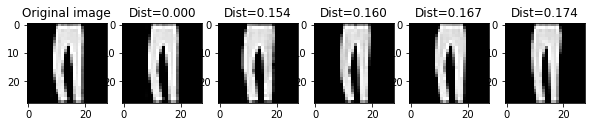

In [25]:
show_similar_annoy(x_test[2])

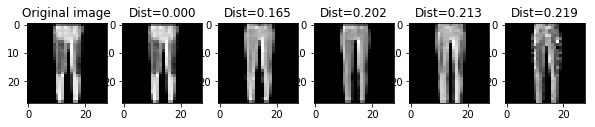

In [26]:
show_similar_annoy(x_test[3])

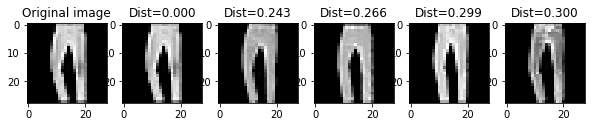

In [27]:
show_similar_annoy(x_test[5])

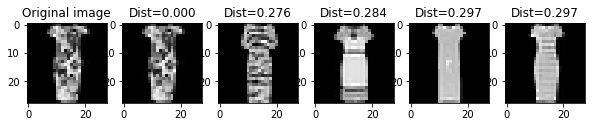

In [28]:
show_similar_annoy(x_test[100])

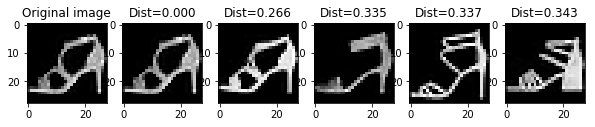

In [29]:
show_similar_annoy(x_test[82])

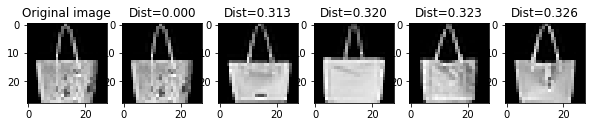

In [30]:
show_similar_annoy(x_test[256])

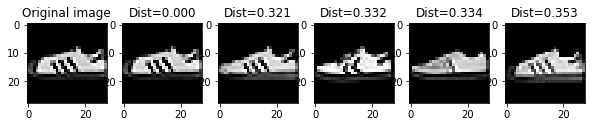

In [31]:
show_similar_annoy(x_test[308])

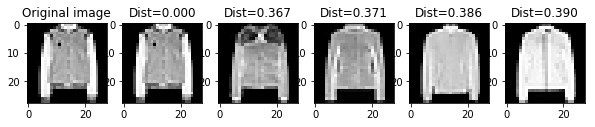

In [32]:
show_similar_annoy(x_test[4289])

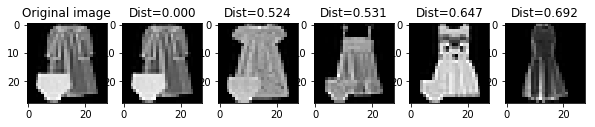

In [33]:
show_similar_annoy(x_test[5012])

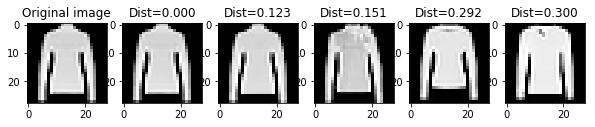

In [34]:
show_similar_annoy(x_test[8024])

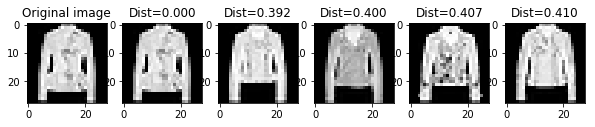

In [35]:
show_similar_annoy(x_test[3026])

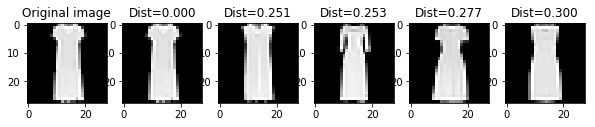

In [36]:
show_similar_annoy(x_test[1034])

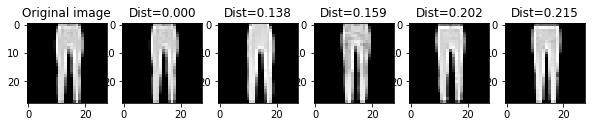

In [37]:
show_similar_annoy(x_test[9065])

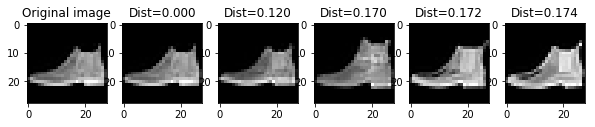

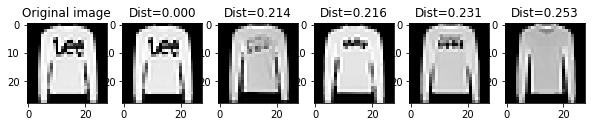

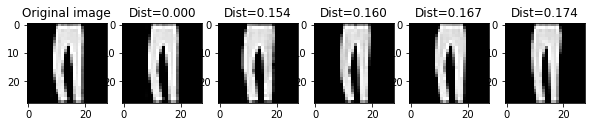

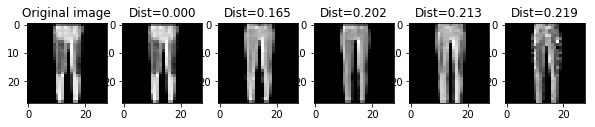

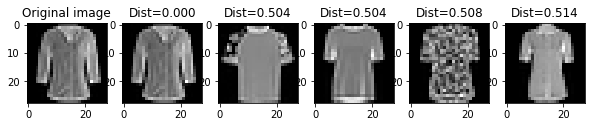

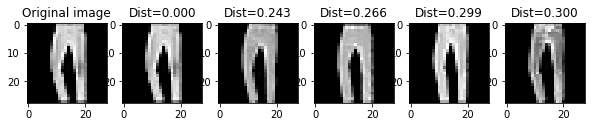

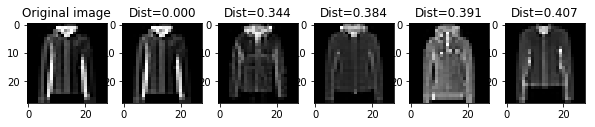

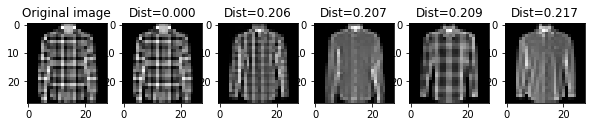

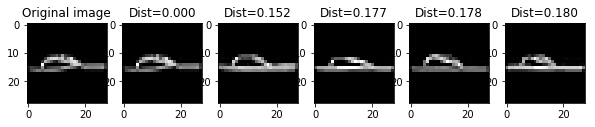

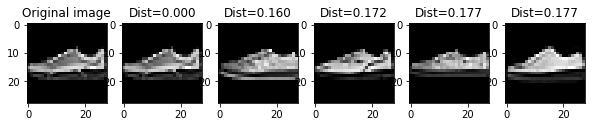

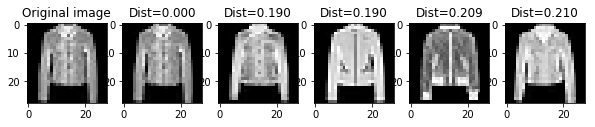

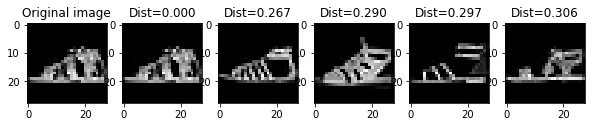

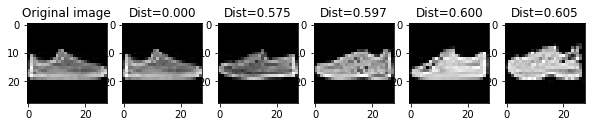

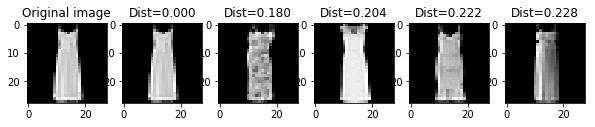

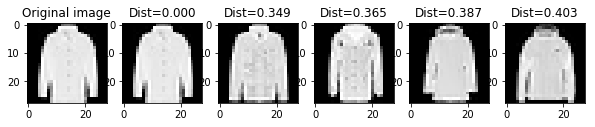

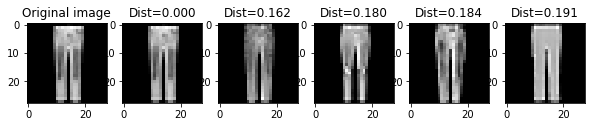

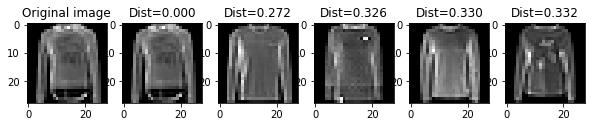

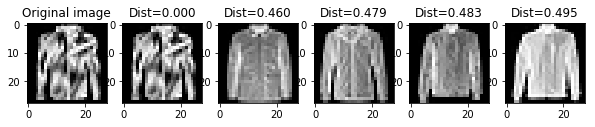

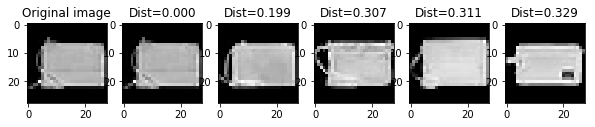

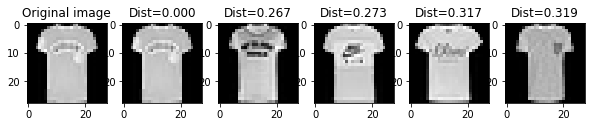

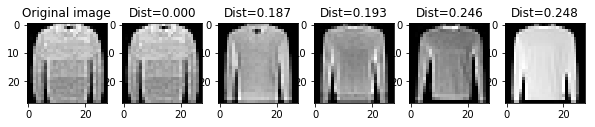

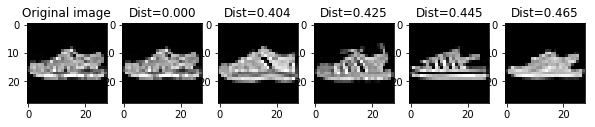

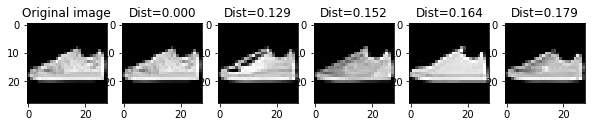

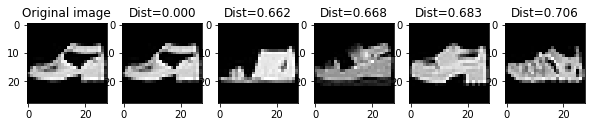

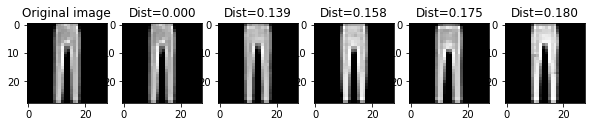

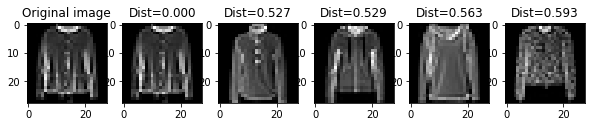

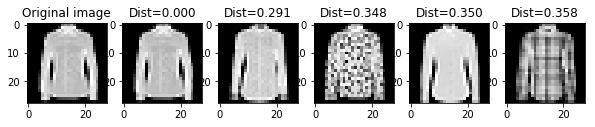

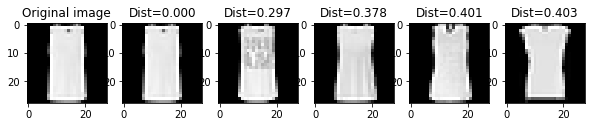

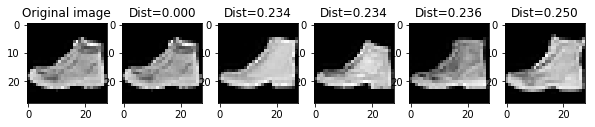

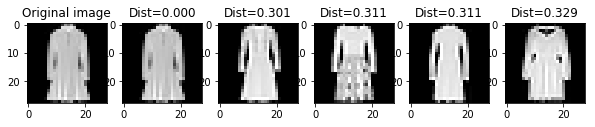

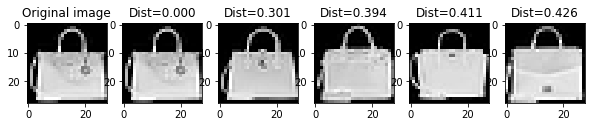

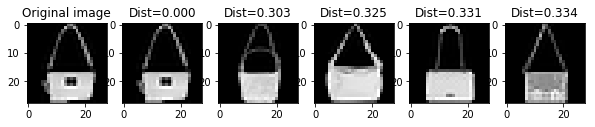

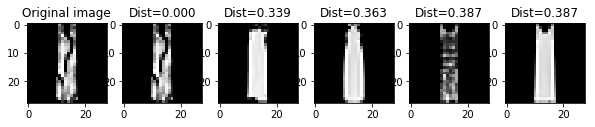

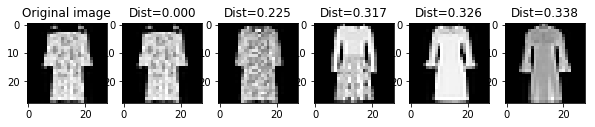

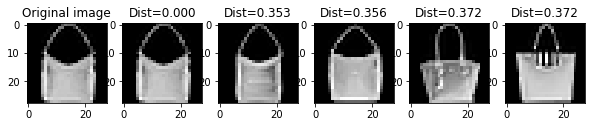

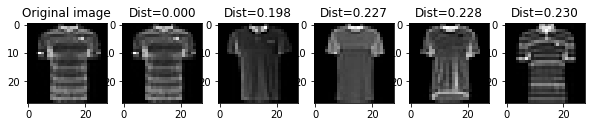

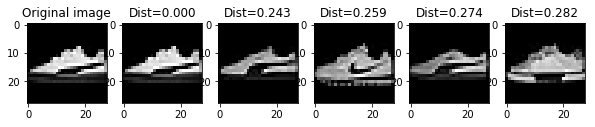

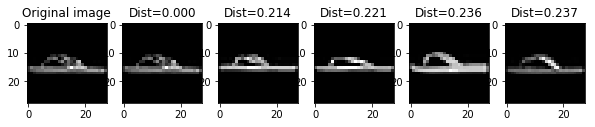

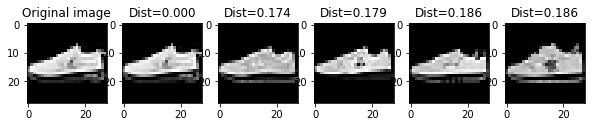

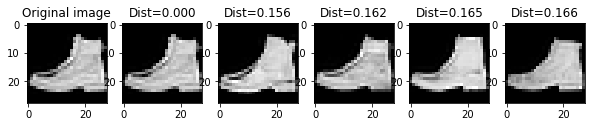

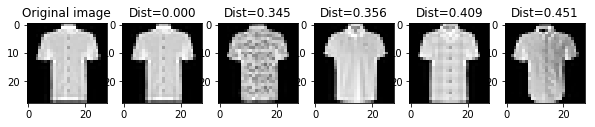

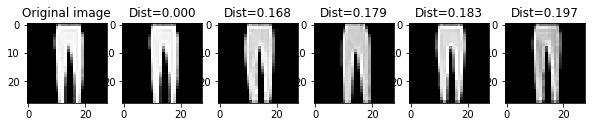

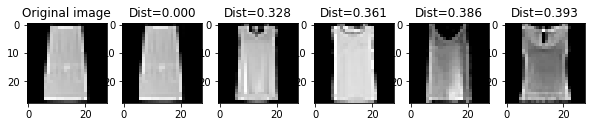

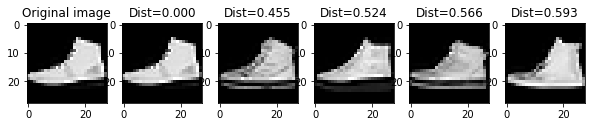

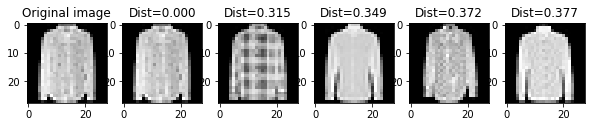

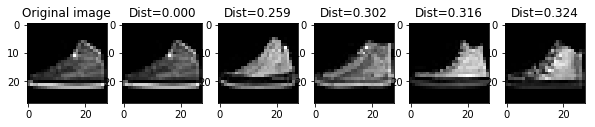

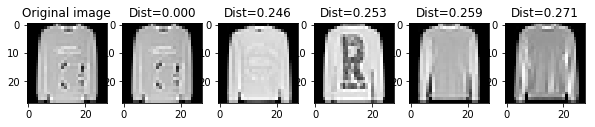

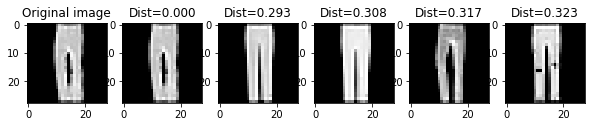

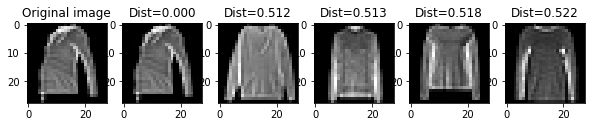

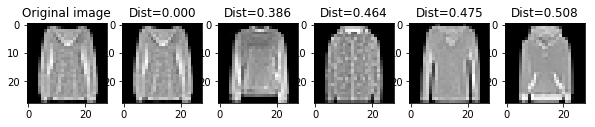

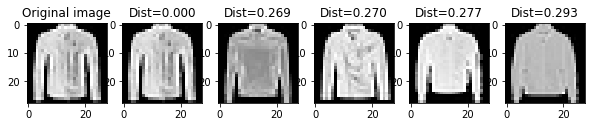

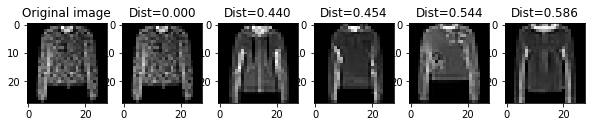

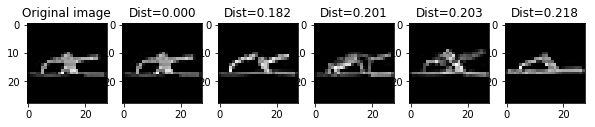

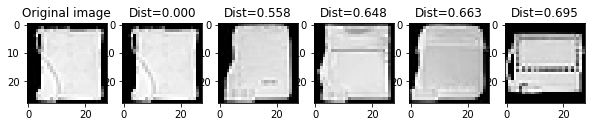

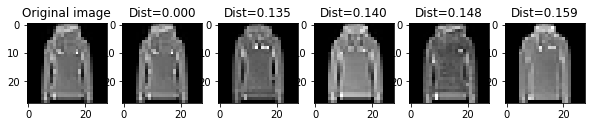

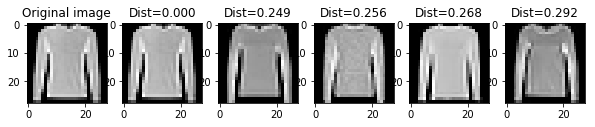

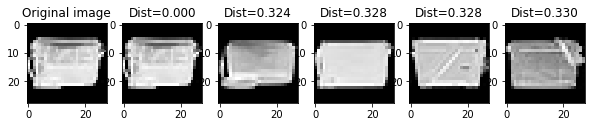

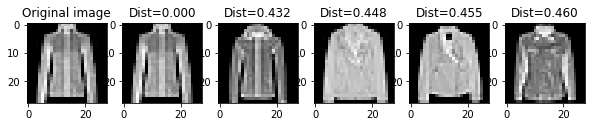

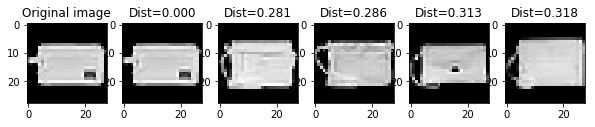

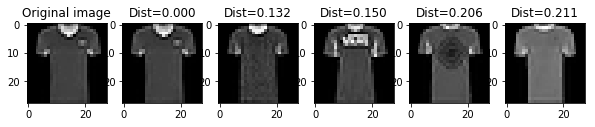

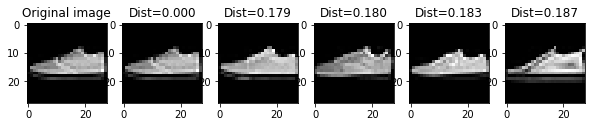

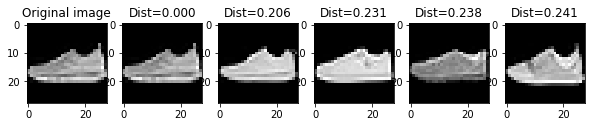

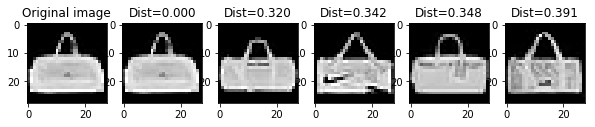

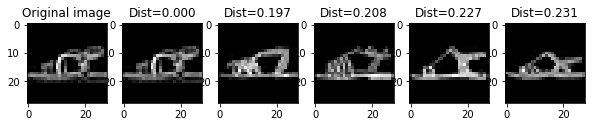

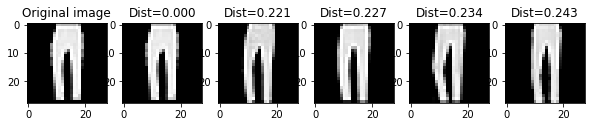

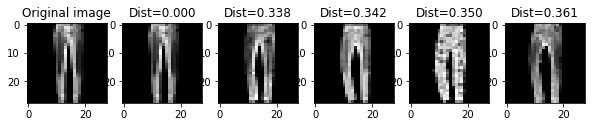

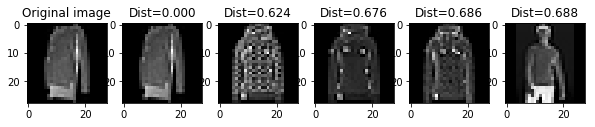

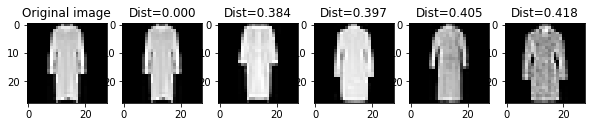

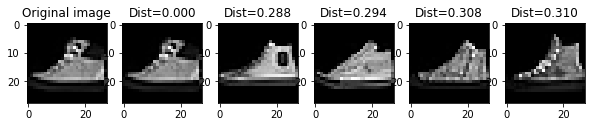

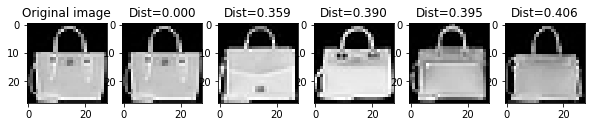

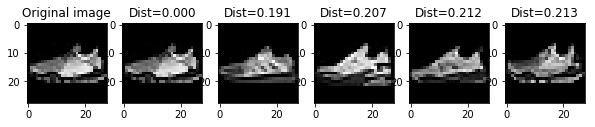

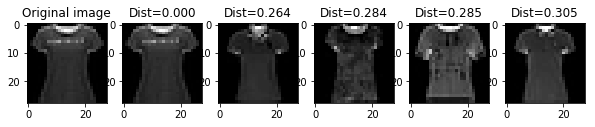

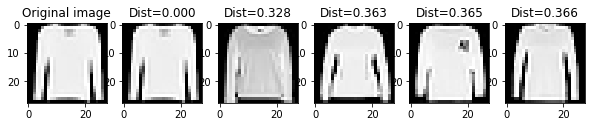

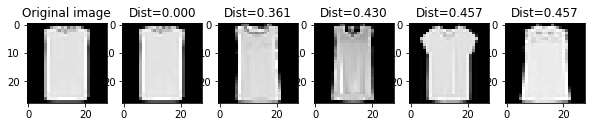

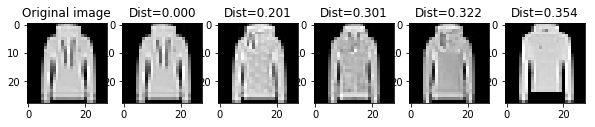

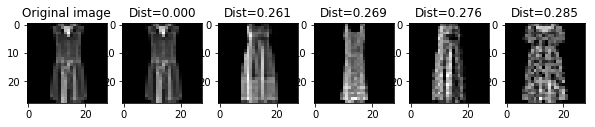

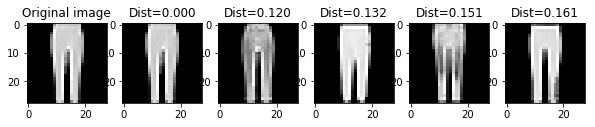

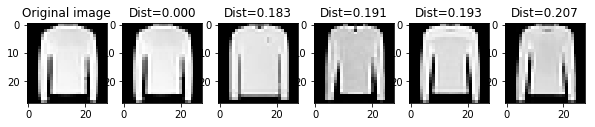

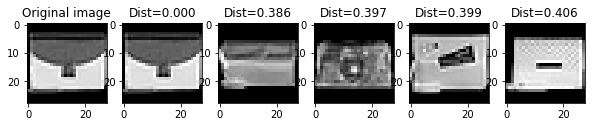

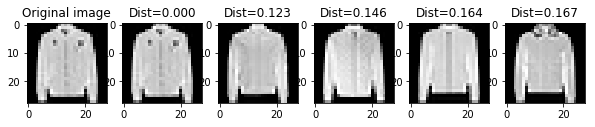

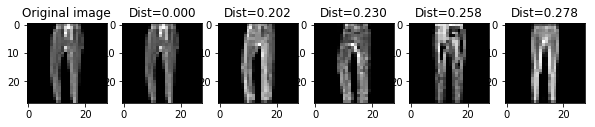

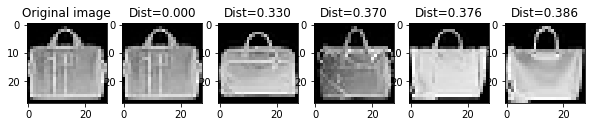

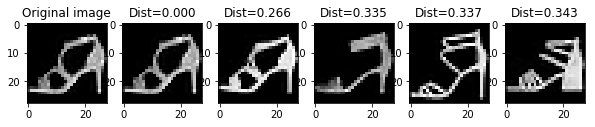

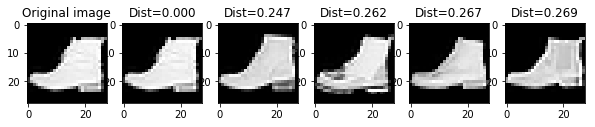

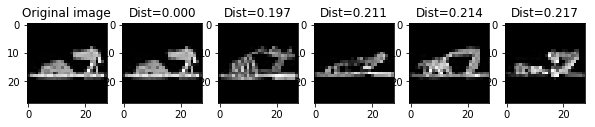

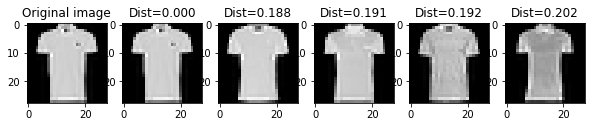

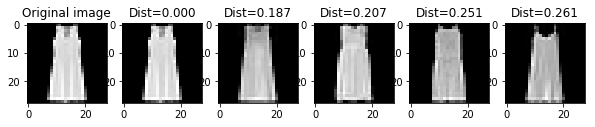

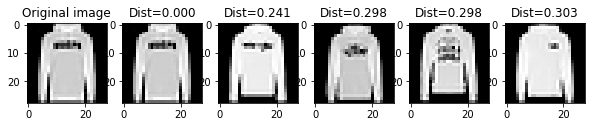

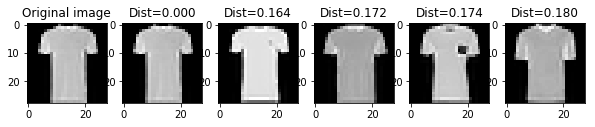

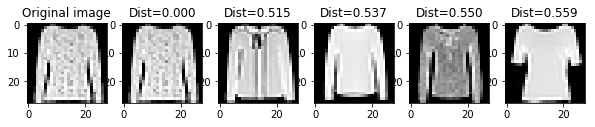

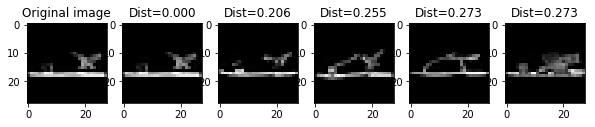

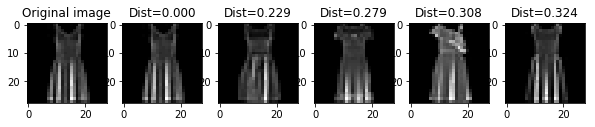

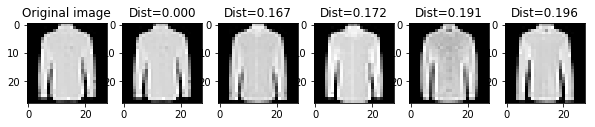

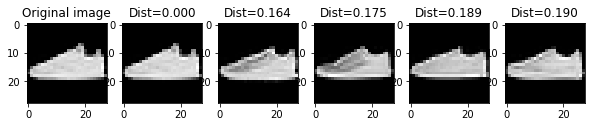

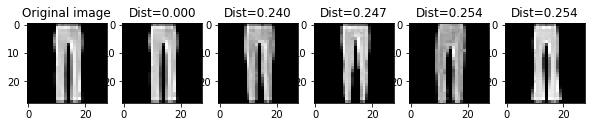

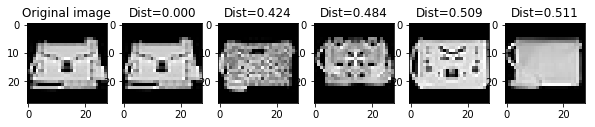

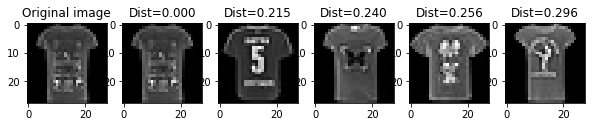

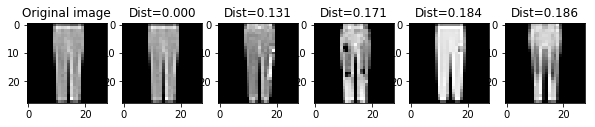

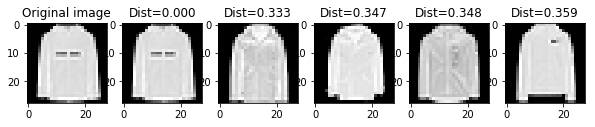

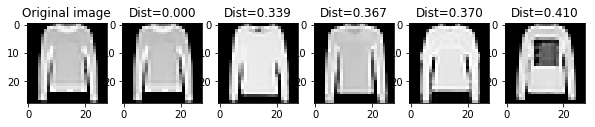

In [38]:
for i in range(100):
    show_similar_annoy(x_test[i])